In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from random import sample

In [2]:
df = pd.read_csv("trajectory.csv")
df.columns = ["time", "vehicle_id", "edge", "lane", "x", "y","toremove"]
del df['toremove']
df.head() # df now holds the data

,time,vehicle_id,edge,lane,x,y
0,3,flow_0.0,gneE0,gneE0_1,6.125964,-11.2
1,4,flow_0.0,gneE0,gneE0_1,7.173879,-11.2
2,5,flow_0.0,gneE0,gneE0_1,8.238620,-11.2
3,5,flow_0.1,gneE0,gneE0_3,5.100000,-4.8
4,6,flow_0.0,gneE0,gneE0_1,9.320816,-11.2


In [3]:
# Obtain all the traces of a particular edge, here gneE0 is chosen
# df_edge = df[(df['vehicle_id'].isin(selected_vehicle_ids)) & (df['edge'] == 'gneE0')]
df_edge = df[df['edge'] == 'gneE0']
vehicle_ids_on_edge = df_edge['vehicle_id'].unique().tolist()
selected_vehicle_ids = sample(vehicle_ids_on_edge, 200) # get 100 vehicle traces
df_mini = df_edge[df_edge['vehicle_id'].isin(selected_vehicle_ids)]
df_mini.head()

,time,vehicle_id,edge,lane,x,y
0,3,flow_0.0,gneE0,gneE0_1,6.125964,-11.2
1,4,flow_0.0,gneE0,gneE0_1,7.173879,-11.2
2,5,flow_0.0,gneE0,gneE0_1,8.238620,-11.2
3,5,flow_0.1,gneE0,gneE0_3,5.100000,-4.8
4,6,flow_0.0,gneE0,gneE0_1,9.320816,-11.2


In [4]:
import numpy as np

Max length of trajectory x: 489
Max length of trajectory y: 489


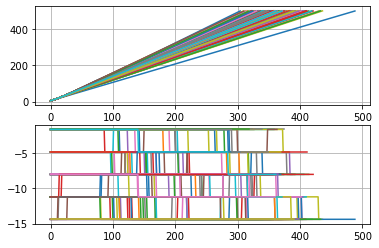

In [5]:
fig = plt.figure()
plt_x = fig.add_subplot(2,1,1)
plt_x.grid(True)
plt_y = fig.add_subplot(2,1,2)
plt_y.grid(True)
max_length_y = 0
max_length_x = 0

x_mat = np.zeros((len(selected_vehicle_ids)),)
x_mat = np.zeros((len(selected_vehicle_ids)),)

for veh_id in selected_vehicle_ids:
    df_of_veh = df_mini[df_mini['vehicle_id'] == veh_id]
    t_vec = df_of_veh['time'].to_numpy()
    t_vec = t_vec - t_vec[0]
    x_vec = df_of_veh['x'].to_numpy()
    y_vec = df_of_veh['y'].to_numpy()
    if x_vec.shape[0] > max_length_x:
        max_length_x = x_vec.shape[0]
    if y_vec.shape[0] > max_length_y:
        max_length_y = y_vec.shape[0]
    plt_x.plot(t_vec, x_vec)
    plt_y.plot(t_vec, y_vec)

print('Max length of trajectory x: {:d}'.format(max_length_x))
print('Max length of trajectory y: {:d}'.format(max_length_y))

In [6]:
z_mat = np.zeros((len(selected_vehicle_ids), max_length_x))
t_mat = None
z_last = np.zeros((len(selected_vehicle_ids,))) # last value of z_vector for each vehicle, for extrapolation!
z_rate = np.zeros((len(selected_vehicle_ids,))) # the speed to linearly extrapolate
z_len = np.zeros((len(selected_vehicle_ids,))) # the speed to linearly extrapolate

for i, veh_id in enumerate(selected_vehicle_ids):
    df_of_veh = df_mini[df_mini['vehicle_id'] == veh_id]
    if t_mat is None:
        t_mat = df_of_veh['time'].to_numpy()
    # t_vec = t_vec - t_vec[0]
    x_vec = df_of_veh['x'].to_numpy()
    y_vec = df_of_veh['y'].to_numpy()
    z_vec = x_vec
    z_len[i] = z_vec.shape[0]
    z_mat[i,:z_vec.shape[0]] = z_vec  
    z_last[i] = z_vec[-1]
    z_rate[i] = (z_vec[-1] - z_vec[-4])/3.

In [7]:
length_desired = 350
z_cutoff = 300 
z_mat_good = np.zeros((z_mat.shape[0], length_desired))
j=0
for i in range(z_mat.shape[0]):
    if z_len[i] < z_cutoff:
        print('Skipping trajectory {} due to being too short!'.format(i))
        continue
    if z_len[i] > length_desired:
        # just trim this trajectory to length desired
        z_mat_good[j,:] = z_mat[i,:length_desired]
        j+=1
        continue 
    if z_len[i] < length_desired:
        # short (but still good enough to be linearly extrapolated)
        zv = z_mat[i,:int(z_len[i])]
        z_mat_good[j,:zv.shape[0]] = zv
        z_mat_good[j, zv.shape[0]:] = z_last[i] + z_rate[i] * np.arange(1, length_desired - zv.shape[0] + 1)
        j+=1

Skipping trajectory 25 due to being too short!
Skipping trajectory 27 due to being too short!
Skipping trajectory 31 due to being too short!
Skipping trajectory 38 due to being too short!
Skipping trajectory 46 due to being too short!
Skipping trajectory 55 due to being too short!
Skipping trajectory 59 due to being too short!
Skipping trajectory 63 due to being too short!
Skipping trajectory 65 due to being too short!
Skipping trajectory 71 due to being too short!
Skipping trajectory 73 due to being too short!
Skipping trajectory 134 due to being too short!
Skipping trajectory 140 due to being too short!
Skipping trajectory 168 due to being too short!
Skipping trajectory 174 due to being too short!
Skipping trajectory 191 due to being too short!


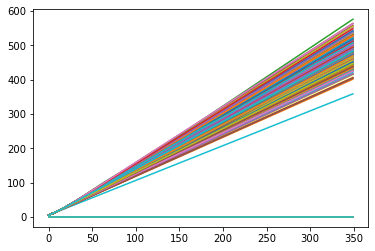

In [8]:
for i in range(z_mat_good.shape[0]):
    plt.plot(z_mat_good[i,:])

In [9]:
# Export the data to CSV to be processed with unsupervised segmentation in R
df_mini[['vehicle_id','time','x','y']].to_csv('edge_trajectories.csv')

Write to pyo file for use with spherical_codes.ipynb

In [10]:
import pickle

with open('trajectories.pyo', 'wb') as f:
    obj2dump = {'y_vec': z_mat_good, 'x_vec': z_mat_good, 't_vec': t_mat}
    pickle.dump(obj2dump, f)

print('Completed writing pyo file')

Completed writing pyo file
